In [ ]:
!pip install wandb torch_geometric gpytorch
!pip install --upgrade gdown

In [ ]:
# #the four parts of the datasets in case of using the notebook from a different google drive
# import gdown
# gdown.download_folder("https://drive.google.com/drive/folders/1-JkyT8aKr9-eC2Pkof6D_qJdASYAXpUj?usp=sharing")
# gdown.download_folder("https://drive.google.com/drive/folders/1-qmcIKbazhHGkb8gRFAjHxDzi0Jv33T-?usp=sharing")
# gdown.download_folder("https://drive.google.com/drive/folders/106k3sK6wrcDzE_6ewGSUKqVD4nXlrIPE?usp=sharing")
# gdown.download_folder("https://drive.google.com/drive/folders/10HjEkProRtYt5ROzamS7SY94JVuuBOxy?usp=sharing")

In [2]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


In [1]:
import torch
"""
https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
"""
from torch_geometric.data  import InMemoryDataset

class WeekGraphs(InMemoryDataset):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])
# dataset = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_dataset_1st_year", week_graphs)


In [2]:
all_points = []
for i in range(1,4):
  dataset = WeekGraphs(f"./drive/MyDrive/bloomberg_graph_{i}")
  for k in range(len(dataset)):
    all_points.append(dataset[k])

In [3]:
from torch_geometric.utils import (
    add_self_loops,
    negative_sampling,
    remove_self_loops ,
)
import torch.nn.functional as F
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score
from sklearn.metrics import precision_score
import warnings
warnings.filterwarnings("ignore")
import time


import numpy as np
import scipy.sparse as sp
from torch import nn
import pandas as pd
# import networkx as nx
import wandb

from tqdm import tqdm
from torch_geometric.data import DataLoader as GraphDataLoader
from typing import List , Dict,Tuple
from torch_geometric.nn import SAGEConv, to_hetero
import torch

import matplotlib.pyplot as plt
import torch_geometric.nn as  gnn
from torch_geometric.data  import Data
from torch_geometric.data import HeteroData

from torch.nn import functional as F
import torch
from torch.optim.adamw import AdamW
import time
from argparse import ArgumentParser
import argparse
import wandb
import numpy as np
import random
import os
import datetime
from tqdm import tqdm
generator = torch.manual_seed(232)
np.random.seed(232)
torch.cuda.manual_seed(232)
torch.cuda.manual_seed_all(232)
random.seed(232)
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood, SoftmaxLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, RFFKernel
from torch.utils.data import TensorDataset, DataLoader



In [4]:


class LSTM(nn.Module):
    def __init__(self, input_size=1, num_layers=2,hidden_size=64, output_size=64, num_steps =15 ):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.batch_norm1 = nn.BatchNorm1d(num_steps)

    def forward(self, x):
        # h0 = torch.zeros(2, x.size(0), 100).to(device) # num_layers * num_directions, batch_size, hidden_size
        # c0 = torch.zeros(2, x.size(0), 100).to(device)
        x = self.batch_norm1(x)
        out, _ = self.lstm1(x)
        # out, _ = self.lstm2(out)
        out = F.relu(self.fc1(out[:, -1, :]))
        return out



In [5]:
class GConv(nn.Module):

    def __init__(self, emb_dim:int=64, num_layers:int=2, encode:bool=False, concat_out:bool=False, device='cpu', dropout=0.2):

        super(GConv,self).__init__()
        self.num_layers = num_layers
        self.gconv_layers = []
        self.norm_layers = []
        self.encode = encode
        for _ in range(num_layers):
            self.gconv_layers.append(gnn.TransformerConv(emb_dim, emb_dim, heads=2, concat=False, dropout=dropout, add_self_loops = True).to(device)) # project=True ()
            if self.encode:
                self.norm_layers.append(nn.LayerNorm(emb_dim).to(device))
        self.gconv_layers = nn.ModuleList(self.gconv_layers)
        self.norm_layers = nn.ModuleList(self.norm_layers)

        self.concat_out = concat_out

    def forward(self, x, edge_index):

        outs = []
        if self.encode:
            outs.append(self.norm_layers[0](self.gconv_layers[0](x, edge_index)))
        else:
            outs.append(self.gconv_layers[0](x, edge_index))
        for i in range(1,self.num_layers):
            if self.encode:
                outs.append(self.norm_layers[i](self.gconv_layers[i](outs[-1], edge_index)))
            else:
                outs.append(self.gconv_layers[i](outs[-1], edge_index))
        if self.concat_out:
            return torch.cat(outs, dim = -1)

        return outs[-1]



class NeuroStock(nn.Module):

  def __init__(self,
               num_timeseries_features=1,
               n_companies=617,
               company_emb_size=32,
               node_emb_size=64,
               article_emb_size=768,
               n_industries=14,
               n_gnn_layers=2,
               use_timeseries_only=False,
               graph_metadata:Tuple=None):
    super(NeuroStock, self).__init__()
    """
    company node representation will be a sum of its embedding and the output of the timeseries model (in this case it's an LSTM)
    """
    self.num_timeseries_features = num_timeseries_features
    self.n_companies = n_companies
    self.company_emb_size = company_emb_size
    self.node_emb_size = node_emb_size
    self.article_emb_size = article_emb_size
    self.n_industries = n_industries
    self.n_gnn_layers = n_gnn_layers
    self.use_timeseries_only = use_timeseries_only
    self.lstm = LSTM(input_size=num_timeseries_features,  hidden_size=company_emb_size, output_size=company_emb_size).to(torch.float)

    if graph_metadata is None:
      raise("You need to pass HeteroData.metadata()")
    self.company_embedding = nn.Embedding(n_companies, company_emb_size).to(torch.float)
    self.project_article = nn.Linear(article_emb_size, node_emb_size).to(torch.float)

    # to_hetero transforms normal gnn aggregation layer to a heterogeneous aggregation layer
    # https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.to_hetero_transformer.to_hetero
    self.g_conv = gnn.to_hetero(GConv(emb_dim=node_emb_size, num_layers=n_gnn_layers), graph_metadata).to(torch.float)
    self.classifier = nn.Linear(node_emb_size, 2).to(torch.float)

  def forward(self, hetero_x:HeteroData, return_representations=False):
    companies_timeseries = self.lstm(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float))
    if self.use_timeseries_only:
      out = self.classifier(companies_timeseries)
      if return_representations:
        return out, companies_timeseries
      return out

    hetero_x["sentence"].x = self.project_article(hetero_x["sentence"].x.to(torch.float))
    companies = self.company_embedding(hetero_x["company"].x)
    # print(hetero_x["company_timeseries"][:,:, -2:-1].to(torch.double).shape, hetero_x["company_timeseries"][:,:, -2:-1].to(torch.float).dtype)
    # company_timeseries is of shape (n_companies*batch_size, n_days, n_features)  the features are "open", "high", "low", "close", "volume"
    hetero_x["company"].x = companies_timeseries + companies  #companies are in shape (n_companies*batch_size, node_emb_size)

    for k in hetero_x.edge_index_dict.keys():
      hetero_x[k].edge_index = hetero_x[k].edge_index.to(torch.int64)
    graph = self.g_conv(hetero_x.x_dict, hetero_x.edge_index_dict)
    out = self.classifier(graph["company"])
    if return_representations:
      return out, graph["company"]
    return out

  def compute_loss(self, out, target):
    loss = F.cross_entropy(out, target)
    return loss


def get_output(neurostock:NeuroStock, points:List[HeteroData]):
  data_loader = GraphDataLoader(
                points,
                batch_size=1, shuffle=False)
  neurostock.eval()
  valid_losses = []
  # continue
  valid_outs = []
  valid_targets = []
  with torch.no_grad():
      for i, batch  in enumerate(data_loader):
        # if i > 2: break
        batch = batch.to(device)
        out = neurostock(batch)
        # print(out.squeeze(-1).unsqueeze(0))
        # print(batch["target"].shape)
        # break
        valid_outs.append(out.unsqueeze(0).cpu().detach())
        valid_targets.append(batch["target"].unsqueeze(0).cpu().detach())
        loss = neurostock.compute_loss(out, batch["target"])
        valid_losses.append(loss.item())
  valid_outs = torch.cat(valid_outs).numpy()
  valid_targets = torch.cat(valid_targets).numpy()
  return valid_outs, valid_targets

def get_output_representations(neurostock:NeuroStock, points:List[HeteroData]):
  data_loader = GraphDataLoader(
                points,
                batch_size=1, shuffle=False)
  neurostock.eval()
  device = next(neurostock.parameters()).device
  valid_losses = []
  # continue
  representations = []
  targets = []
  with torch.no_grad():
      for i, batch  in enumerate(data_loader):
        # if i > 2: break
        batch = batch.to(device)
        out = neurostock.forward(batch, return_representations=True)[1]
        representations.append(out.cpu().detach())
        targets.append(batch["target"].cpu().detach())

  representations = torch.cat(representations)
  targets = torch.cat(targets)
  return representations, targets




In [6]:

class GPModel(ApproximateGP):
    def __init__(self, num_classes, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RFFKernel(num_samples=50),
            batch_shape=torch.Size((num_classes,)),
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



def get_gp_model(gp_train_x, gp_train_y)-> Tuple[ApproximateGP, DirichletClassificationLikelihood]:


  inducing_points = gp_train_x[np.linspace(0, len(gp_train_x)-1, 500, dtype=int)]


  likelihood = DirichletClassificationLikelihood(gp_train_y, learn_additional_noise=True, ).to(torch.double)
  # likelihood.noise = torch.ones_like(likelihood.noise)

  model = GPModel(likelihood.num_classes, inducing_points).to(torch.double)

  if torch.cuda.is_available():
      model = model.cuda()
      likelihood = likelihood.cuda()
  return model,  likelihood

def train_gp(
    gp:GPModel,
    likelihood:DirichletClassificationLikelihood,
    train_dataset:torch.utils.data.Dataset,
    valid_x, valid_y,
    test_x, test_y,
    n_epochs=5, least_var_k=100)->float:

  gp_optimizer = torch.optim.Adam([
      {'params': gp.parameters()},
      {'params': likelihood.parameters()},
  ], lr=0.0001)
  train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
  best_val_acc = 0
  mll = gpytorch.mlls.VariationalELBO(likelihood, gp, num_data=len(train_dataset))
  for i in tqdm(range(n_epochs)):
      # Within each iteration, we will go over each minibatch of data
      gp.train()
      likelihood.train()

      for x_batch, y_batch in train_loader:
        x_batch = x_batch.to("cuda").to(torch.double)
        y_batch = y_batch.to("cuda").to(torch.double)
        gp_optimizer.zero_grad()

        output = gp(x_batch)
        loss = -mll(output, y_batch.T).sum()

        loss.backward()
        gp_optimizer.step()

      gp.eval()
      likelihood.eval()
      lowest_var_accs = []
      for i in range(len(valid_x)// 616):
        with torch.no_grad():
            test_dist = gp_model(valid_x[i*616: (i+1)*616].to("cuda").to(torch.double))
            pred_means = test_dist.loc.detach().cpu()
            lower_bound, upper_bound = likelihood(test_dist).confidence_region()


        vars = [ ]
        for lb, ub, label in zip(lower_bound.detach().cpu().T, upper_bound.detach().cpu().T, pred_means.argmax(0)):
          vars.append(abs(lb[label])+abs(ub[label]))
        vars = torch.tensor(vars)
        lowest_var_acc = (pred_means.argmax(0)[vars.argsort()[:least_var_k]] == valid_y[vars.argsort()[:least_var_k]]).numpy().mean()
        lowest_var_accs.append(lowest_var_acc)
      if np.mean(lowest_var_acc) > best_val_acc:
        best_val_acc = np.mean(lowest_var_acc)
        torch.save(gp, "./best_gp.pt")
        torch.save(likelihood, "./best_likelihood.pt")

  gp = torch.load("./best_gp.pt")
  likelihood = torch.load("./best_likelihood.pt")
  gp.eval()
  likelihood.eval()
  lowest_var_accs = []
  all_vars = []
  for i in range(len(test_x)// 616):
    with torch.no_grad():
        test_dist = gp_model(test_x[i*616: (i+1)*616].to("cuda").to(torch.double))
        pred_means = test_dist.loc.detach() .cpu()
        lower_bound, upper_bound = likelihood(test_dist).confidence_region()


    vars = [ ]
    for lb, ub, label in zip(lower_bound.detach().cpu().T, upper_bound.detach().cpu().T, pred_means.argmax(0)):
      vars.append(abs(lb[label])+abs(ub[label]))
    vars = torch.tensor(vars)
    all_vars.append(vars[vars.argsort()[:least_var_k]])
    lowest_var_acc = (pred_means.argmax(0)[vars.argsort()[:least_var_k]] == test_y[vars.argsort()[:least_var_k]]).numpy().mean()
    lowest_var_accs.append(lowest_var_acc)

  return np.mean(lowest_var_accs), torch.cat(all_vars)

In [7]:
import os
os.environ["WANDB_API_KEY"]="4d60aa176a9e71fedbbaddb7ea594784ac8cc1ad"

In [8]:
!wandb login

wandb: Currently logged in as: mirette-gp. Use `wandb login --relogin` to force relogin


In [12]:
import sys
import wandb

"""
file_path_in_run username/project/run_id
"""

def restore_file_wandb(file_path:str, run_name:str):
    # if not os.path.exists("/".join(file_path.split("/")[:-1])):
    #     os.makedirs("/".join(file_path.split("/")[:-1]))
    wandb.restore(file_path, run_path=run_name)

In [ ]:
restore_file_wandb("neurostock_lstm.pt", "mirette-gp/bloomberg_graph/6dsvbqqd")
restore_file_wandb("neurostock_gnn.pt", "mirette-gp/bloomberg_graph/915dbdpv")

In [22]:
import wandb

from tqdm import tqdm


train_config = {
  "n_epochs" : 2,
  "node_emb_size" : 128,
  "lr" : 0.001,
  "weight_decay" : 0.01,
  "step_size" : 7,
  "start_day" : 500,
  "train_size" : 300,
  "test_interval" : 400,
  "train_batch_size": 2,
  "use_timeseries_only": False,
  "reset_parameters" : False,
  "reset_parameters_freq" : 5,
  "highest_conf_k" : 300,
  "model_file_name" : "./neurostock_gnn.pt",
  "run_name" : "gnn_gp_benchmark_100_gp_less_best_val_gp_epoch_K300_best",
  "project_name":  "bloomberg_graph",
  "wandb_mode" : "online",
  "gp_train_days" : 20,
  "gp_val_days" : 2,
  "gp_epochs" : 6,
}
wandb.finish()
wandb.init(
    project=train_config["project_name"],
    name=train_config["run_name"],
    config=train_config,
    mode=train_config["wandb_mode"])
# warmup_steps=
neurostock = NeuroStock(
    node_emb_size=train_config["node_emb_size"],
    company_emb_size=train_config["node_emb_size"],
    use_timeseries_only=train_config["use_timeseries_only"],
    graph_metadata=all_points[0].metadata())

neurostock.to('cuda')
device = next(neurostock.parameters()).device
optimizer =  torch.optim.AdamW(neurostock.parameters(),
                               lr=train_config["lr"],
                               weight_decay=train_config["weight_decay"] )
accs = []
accum_companies = []
high_conf_avgs = []
gp_accs = []
gp_vars = []
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1,  total_iters=warmup_steps)
for split_index, split in tqdm(enumerate(range(0, train_config["test_interval"], train_config["step_size"]))):

  if train_config["reset_parameters"] and (split_index + 1) % train_config["reset_parameters_freq"]  == 0 :
    for layer in neurostock.children():
      if hasattr(layer, 'reset_parameters'):
          layer.reset_parameters()

  train_loader = GraphDataLoader(
      all_points[train_config["start_day"]+split:train_config["start_day"]+split+train_config["train_size"]],
      batch_size=train_config["train_batch_size"], shuffle=True)
  test_loader = GraphDataLoader(
      all_points[train_config["start_day"]+split+train_config["train_size"]:train_config["start_day"]+split+train_config["train_size"]+train_config["step_size"]],
      batch_size=1, shuffle=False)

  for e in tqdm(range(train_config["n_epochs"])):
      train_losses= []
      neurostock.train()
      train_outs = []
      train_targets = []
      for batch  in train_loader:
          # with torch.autocast(device_type="cuda", dtype=torch.float16):
          # with torch.autocast(device_type="cuda", dtype=torch.float16):
          batch = batch.to(device)
          out = neurostock(batch)
          train_outs.append(out.cpu().detach().unsqueeze(0))
          train_targets.append(batch["target"].cpu().detach().unsqueeze(0))
          loss = neurostock.compute_loss(out, batch["target"])
          optimizer.zero_grad()
          train_losses.append(loss.item())
          loss.backward()
          optimizer.step()
          # lr_scheduler.step()

      neurostock.eval()
      valid_losses = []
      # continue
      valid_outs = []
      valid_targets = []
      with torch.no_grad():

          for i, batch  in enumerate(test_loader):
            # if i > 2: break

            batch = batch.to(device)
            out = neurostock(batch)
            valid_outs.append(out.cpu().detach().unsqueeze(0))
            valid_targets.append(batch["target"].cpu().detach().unsqueeze(0))
            loss = neurostock.compute_loss(out, batch["target"])
            valid_losses.append(loss.item())

      valid_outs = torch.cat(valid_outs).numpy()
      valid_targets = torch.cat(valid_targets).numpy()
      acc_per_company = (valid_outs.argmax(-1) == valid_targets).mean(axis=0)
      high_acc_companies = np.where(acc_per_company >= 0.7)[0]

      valid_acc = (valid_outs.argmax(-1) == valid_targets).mean()
      train_outs = torch.cat(train_outs).numpy()
      train_targets = torch.cat(train_targets).numpy()
      train_acc = (train_outs.argmax(-1) == train_targets).mean()
      # if e == (n_epochs- 1) :
  representations, target = get_output_representations(neurostock,
                                                       all_points[train_config["start_day"]+split+train_config["train_size"]-train_config["gp_train_days"]:train_config["start_day"]+split+train_config["train_size"]+train_config["step_size"]])

  gp_train_x, gp_train_y = representations[:train_config["gp_train_days"]*616], target[:train_config["gp_train_days"]*616]
  gp_valid_x, gp_valid_y = gp_train_x[-train_config["gp_val_days"]*616:], gp_train_y[-train_config["gp_val_days"]*616:]
  gp_train_x, gp_train_y = gp_train_x[:-train_config["gp_val_days"]*616], gp_train_y[:-train_config["gp_val_days"]*616]

  gp_test_x, gp_test_y = representations[train_config["gp_train_days"]*616:], target[train_config["gp_train_days"]*616:]
  gp_model, likelihood = get_gp_model(gp_train_x, gp_train_y)
  train_dataset = TensorDataset(gp_train_x, likelihood.transformed_targets.T)

  gp_uncertainty_acc, vars = train_gp(gp_model, likelihood, train_dataset, gp_valid_x, gp_valid_y, gp_test_x, gp_test_y, n_epochs=train_config["gp_epochs"], least_var_k=train_config["highest_conf_k"])

  high_confidence_accs = []
  for out, target in zip(valid_outs, valid_targets):
    predicted_label = out.argmax(-1)
    confidence = out.max(-1)
    predicted_label = predicted_label[confidence.argsort()[-train_config["highest_conf_k"]:]]
    target = target[confidence.argsort()[-train_config["highest_conf_k"]:]]
    high_confidence_accs.append((target ==predicted_label).mean())
  high_conf_avgs.append(sum(high_confidence_accs)/len(high_confidence_accs))

  wandb.log({
          "train_loss" : np.mean(train_losses),
          "valid_loss" : np.mean(valid_losses),
          "valid_acc" : valid_acc,
          "high_confidence_acc" : sum(high_confidence_accs)/len(high_confidence_accs),
          "valid_n_high" : (acc_per_company >= 0.7).sum(),
          "train_acc" : train_acc,
          "gp_uncertainty_split_acc": gp_uncertainty_acc,
    })
  gp_accs.append(gp_uncertainty_acc)
  gp_vars.append(vars.unsqueeze(0))
  accs.append(valid_acc)
  # wandb.log({"avg_acc": np.mean(valid_acc)})
  accum_companies.append(high_acc_companies)
# wandb.finish()

long_range_outputs, long_range_true = get_output(neurostock, all_points[train_config["start_day"]+split+train_config["train_size"]+train_config["step_size"]:])

all_high = []
for k in  accum_companies:
  all_high.extend(k)

torch.save(neurostock, train_config["model_file_name"])
wandb.save(train_config["model_file_name"])


wandb.log({"avg_acc": np.mean(accs),
           "high_conf_avgs" : np.mean(high_conf_avgs),
           "high_conf_acc_std" : np.std(high_conf_avgs),
           "higher_0.7_mean": np.mean([len(h) for h in accum_companies]),
           "higher_0.7_std": np.std([len(h) for h in accum_companies]),
           "avg_high_company_occurrence": np.mean(pd.Series(all_high).value_counts()[:train_config["highest_conf_k"]].values),
           "long_range_acc" : (long_range_outputs.argmax(-1) == long_range_true).mean(),
           "avg_gp_acc" : np.mean(gp_accs),
           "std_gp_acc" : np.std(gp_accs),
           })
wandb.finish()

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:23<00:00,  5.89s/it]

100%|██████████| 14/14 [00:35<00:00,  2.55s/it]
1it [01:00, 60.25s/it]
100%|██████████| 4/4 [00:24<00:00,  6.14s/it]

100%|██████████| 14/14 [00:35<00:00,  2.54s/it]
2it [02:01, 60.75s/it]
100%|██████████| 4/4 [00:24<00:00,  6.03s/it]

100%|██████████| 14/14 [00:36<00:00,  2.58s/it]
3it [03:02, 61.10s/it]
100%|██████████| 4/4 [00:24<00:00,  6.03s/it]

100%|██████████| 14/14 [00:35<00:00,  2.54s/it]
4it [04:03, 61.00s/it]
100%|██████████| 4/4 [00:24<00:00,  6.04s/it]

100%|██████████| 14/14 [00:35<00:00,  2.54s/it]
5it [05:04, 61.04s/it]
100%|██████████| 4/4 [00:25<00:00,  6.40s/it]

100%|██████████| 14/14 [00:35<00:00,  2.55s/it]
6it [06:07, 61.50s/it]
100%|██████████| 4/4 [00:24<00:00,  6.18s/it]

100%|██████████| 14/14 [00:35<00:00,  2.52s/it]
7it [07:08, 61.43s/it]
100%|██████████| 4/4 [00:25<00:00,  6.38s/it]

100%|██████████| 14/14 [00:35<00:00,  2.57s/it]
8it [08:10, 61.73s/it]
100%|██████████| 4/4 [00:25<00:00,  6

avg_acc,▁
avg_gp_acc,▁
avg_high_company_occurrence,▁
gp_uncertainty_split_acc,▄▄▄▆▃▄▂▅▃▅█▁▄▃▅▃▆▄▇▄▄▅▃▃▅▃▆▂▂▆▆▃▇▃▂▁▄▃▄▁
high_conf_acc_std,▁
high_conf_avgs,▁
high_confidence_acc,▅▃▄▅▄█▅▇▇▃▆▆▆▄▁▆▅▃▃▆▅▆▅▃▃▅▄▃▇▅▆▅▆▂▄▆▄▄▃▃
higher_0.7_mean,▁
higher_0.7_std,▁
long_range_acc,▁
std_gp_acc,▁


<Axes: >

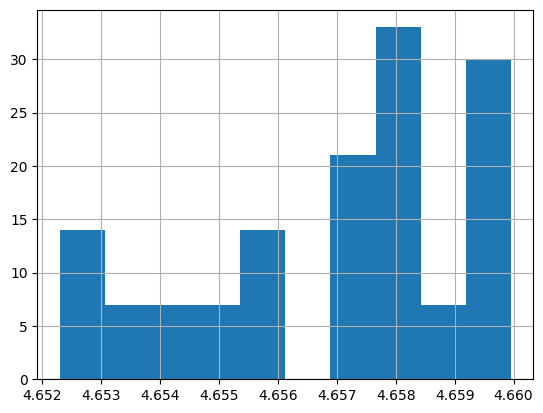

In [14]:
pd.Series(gp_vars[np.argsort(gp_accs)[-5:]][1]).hist()

In [ ]:
# just for testing #######################################
# gp_optimizer = torch.optim.Adam([
#       {'params': gp_model.parameters()},
#       {'params': likelihood.parameters()},
#   ], lr=0.01)
# train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# mll = gpytorch.mlls.VariationalELBO(likelihood, gp_model, num_data=len(train_dataset))
# num_epochs = 5
# for i in tqdm(range(num_epochs)):
#     # Within each iteration, we will go over each minibatch of data
#     gp_model.train()
#     likelihood.train()

#     for x_batch, y_batch in train_loader:
#         x_batch = x_batch.to("cuda").to(torch.float32)
#         y_batch = y_batch.to("cuda").to(torch.float32)
#         gp_optimizer.zero_grad()

#         output = gp_model(x_batch)
#         # print(output.shape)
#         # print(y_batch.shape)
#         loss = -mll(output, y_batch.T)
#         loss = loss.sum()
#         loss.backward()
#         gp_optimizer.step()


# gp_model.eval()
# likelihood.eval()
# lowest_var_accs = []
# for i in range(len(gp_test_x)// 616):
#   with torch.no_grad():
#       test_dist = gp_model(gp_test_x[i*616: (i+1)*616].to("cuda").to(torch.double))
#       pred_means = test_dist.loc.detach().cpu()
#       lower_bound, upper_bound = likelihood(test_dist).confidence_region()


#   vars = [ ]
#   for lb, ub, label in zip(lower_bound.detach().cpu().T, upper_bound.detach().cpu().T, pred_means.argmax(0)):
#     vars.append(abs(lb[label])+abs(ub[label]))
#   vars = torch.tensor(vars)
#   lowest_var_acc = (pred_means.argmax(0)[vars.argsort()[:100]] == gp_test_y[vars.argsort()[:100]]).numpy().mean()
#   lowest_var_accs.append(lowest_var_acc)
# np.mean(lowest_var_accs)

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


0.724